实验目的
+ 了解语音信号分帧与加窗的重要性和基本原理；
+ 能编程实现分帧函数，并恢复。
+ 掌握消除趋势项、直流项的方法；
+ 掌握语音信号预加重的原理及方法；
+ 掌握语音信号预滤波的目的和方法。

In [17]:
# -*- coding:utf-8
import numpy as np
import soundfile
import pyaudio #录制和播放
import wave # 导入wave库，处理音频
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile #读取wav提取数据
from pydub import AudioSegment #　音频处理
plt.rcParams['font.family'] = 'simhei'
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体（可以根据需要选择其他字体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

D:\IT\anaconda3\envs\voice_learning\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


#  根据语音分帧的思想，编写分帧函数

In [18]:
def enframe(x, win, inc):
    frame_length = len(win)
    num_frames = (len(x) - frame_length) // inc + 1

    frameout = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        start = i * inc
        end = start + frame_length
        frameout[i, :] = x[start:end] * win

    return frameout

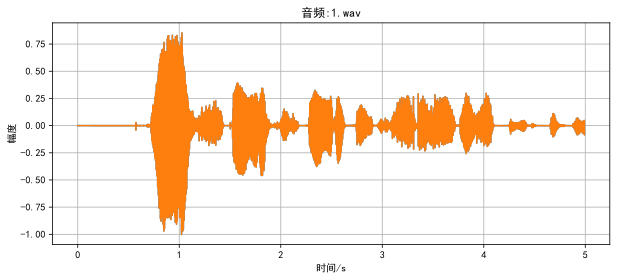

In [30]:
# 读取 WAV 文件
sample_rate, data = wavfile.read("../实验3.wav")
# 获取信号的时长（秒）
duration = len(data) / sample_rate
# 创建时间轴（横轴）数据
time_axis = np.arange(data.shape[0]) / sample_rate
# 归一化音频数据
normalized_data = data / np.max(np.abs(data),axis=0)
# 绘制图形
plt.figure(figsize=(10, 4))
plt.plot(time_axis, normalized_data)
plt.xlabel("时间/s")
plt.ylabel("幅度")
plt.title("音频:1.wav")
plt.grid(True)
plt.show()

In [31]:
# 分帧处理
frame_length = 0.06 * sample_rate  # 帧长为20毫秒
frame_shift = 0.03 * sample_rate  # 帧移为10毫秒
framesout = enframe(data, np.ones(int(frame_length)), int(frame_shift))

ValueError: operands could not be broadcast together with shapes (960,2) (960,) 

In [32]:
framesout.shape

(165, 960)

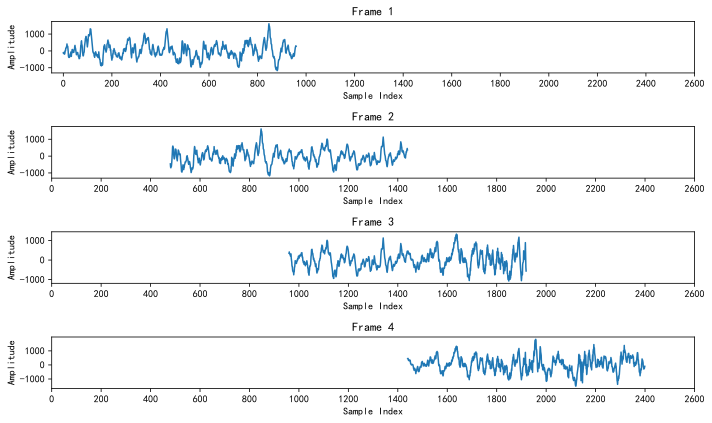

In [33]:
# 绘制连续四帧语音信号
num_frames_to_plot = 4
plt.figure(figsize=(10, 6))
for i in range(num_frames_to_plot):
    plt.subplot(num_frames_to_plot,1, i + 1)
    x_coordinates = np.arange(i * (len(framesout[i]) // 2), i * len(framesout[i])//2 + len(framesout[i]))
    plt.plot(x_coordinates, framesout[i])
    plt.title(f'Frame {i + 1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
            # 手动设置刻度标签
    x_ticks = np.arange(0,2800, 200)  # 生成刻度标签
    x_tick_labels = [str(x) for x in x_ticks]  # 将刻度标签转为字符串
    plt.xticks(x_ticks, x_tick_labels)  # 设置x轴刻度标签
plt.tight_layout()
plt.show()

# 编程实现矩形窗、汉明窗和汉宁窗

In [34]:
# 矩形窗（Rectangular Window）
def rectangular_window(N):
    return np.ones(N)

# 汉明窗（Hamming Window）
def hamming_window(N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))

# 汉宁窗（Hanning Window）
def hanning_window(N):
    return 0.5 * (1 - np.cos(2 * np.pi * np.arange(N) / (N - 1)))

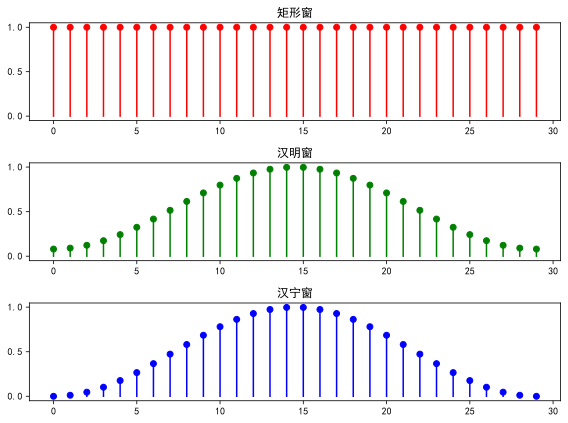

In [35]:
# 窗口长度
N = 30
t = np.linspace(0, N, N, endpoint=False)  # 生成时间序列
# 生成窗函数
rect_window = rectangular_window(N)
hamming_win = hamming_window(N)
hanning_win = hanning_window(N)

# 绘制窗函数
plt.figure(figsize=(8, 6))
plt.subplot(3,1, 1)
for i in range(len(rect_window)):
    plt.plot([t[i], t[i]], [0, rect_window[i]], color='red')  # 使用红色画矩形窗
plt.scatter(t, rect_window, color='red')  # 散点图也设置为红色
plt.title('矩形窗')

plt.subplot(3, 1, 2)
plt.scatter(t, hamming_win, color='green')  # 使用绿色画汉明窗的散点图
for i in range(len(hamming_win)):
    plt.plot([t[i], t[i]], [0, hamming_win[i]], color='green')  # 使用绿色画汉明窗
plt.title('汉明窗')

plt.subplot(3, 1, 3)
plt.scatter(t, hanning_win, color='blue')  # 使用蓝色画汉宁窗的散点图
plt.title('汉宁窗')
for i in range(len(hanning_win)):
    plt.plot([t[i], t[i]], [0, hanning_win[i]], color='blue')  # 使用蓝色画汉宁窗
plt.tight_layout()
plt.show()


# 编程实现 WOLA 的全过程（中间信号处理不做），观察信号的复原程度

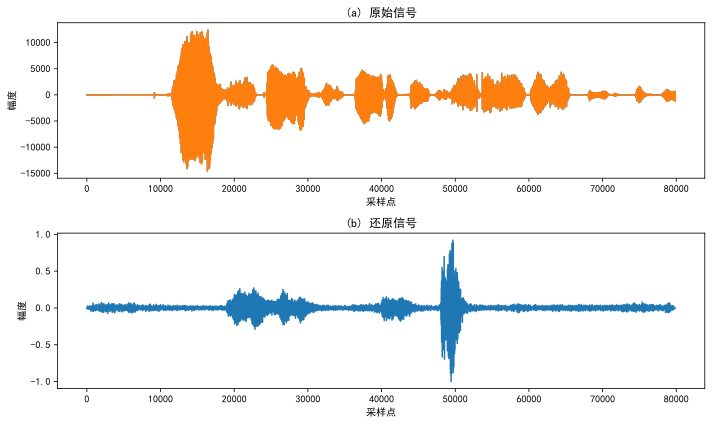

In [36]:
# 合成信号
reconstructed_signal = np.zeros(len(data))

# 对每个帧进行叠加合成重建信号
for i, frame in enumerate(framesout):
    frame_length = len(frame)
    frame_shift = int(0.5 * frame_length)  # 重叠部分为帧长度的一半
    start = i * frame_shift
    end = start + frame_length
    reconstructed_signal[start:end] += frame

# 对重建信号进行归一化处理
reconstructed_signal /= np.max(np.abs(reconstructed_signal), axis=0)

# 绘制原始信号和重建信号
plt.figure(figsize=(10, 6))

# 绘制原始信号
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title("(a) 原始信号")
plt.xlabel("采样点")
plt.ylabel("幅度")

# 绘制重建信号
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.title("(b) 还原信号")
plt.xlabel("采样点")
plt.ylabel("幅度")

plt.tight_layout()
plt.show()


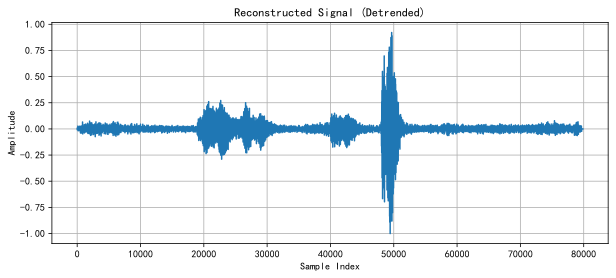

In [37]:
# 去线性趋势项函数
def detrend_linear(signal):
    t = np.arange(len(signal))
    p = np.polyfit(t, signal, 1)  # 用线性多项式拟合信号
    detrended_signal = signal - np.polyval(p, t)  # 减去线性趋势项
    return detrended_signal

# 去线性趋势
reconstructed_signal_detrended = detrend_linear(reconstructed_signal)

# 绘制去趋势后的信号
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_signal_detrended)
plt.title("Reconstructed Signal (Detrended)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# 设计一个低通滤波器，并绘出其幅频和相频曲线

In [38]:
from scipy import signal
from scipy.io import wavfile
# 设计低通滤波器
fs = 8000  # 采样频率
Wp = 60.0  # 通带截止频率
Ws = 50.0  # 阻带截止频率
Rp = 3.0   # 通带最大衰减
Rs = 80.0  # 阻带最小衰减

In [39]:
# 计算滤波器阶数
n, Wn = signal.buttord(Wp, Ws, Rp, Rs, fs=fs)
# 设计Butterworth滤波器
b, a = signal.butter(n, Wn, btype='low', analog=False, fs=fs)


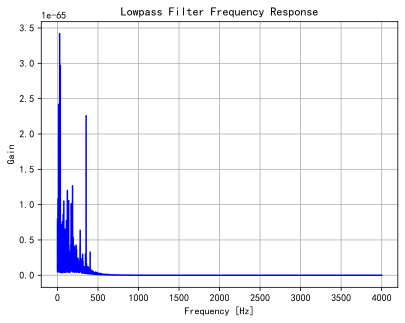

In [40]:
# 绘制幅频响应曲线
w, h = signal.freqz(b, a, worN=8000)
plt.figure()
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


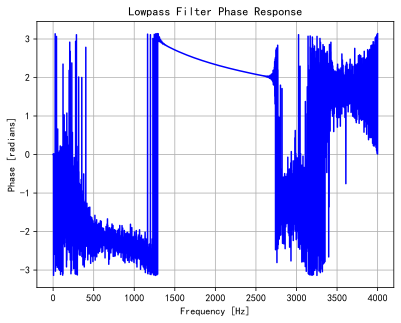

In [41]:

# 绘制相频响应曲线
plt.figure()
plt.plot(0.5 * fs * w / np.pi, np.angle(h), 'b')
plt.title("Lowpass Filter Phase Response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid()
plt.show()

# 预加重

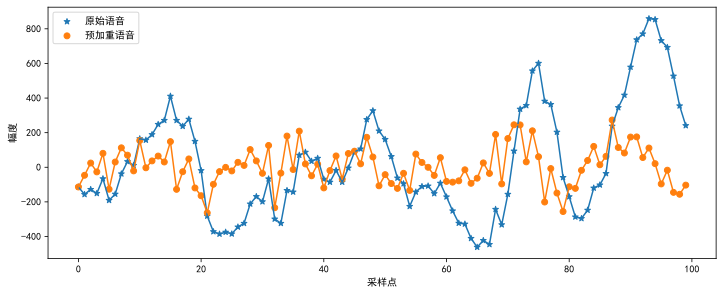

In [13]:

def preemphasis(signal, coefficient=0.97):
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])

# 读取语音信号
sample_rate, data = wavfile.read('../01.wav')

# 应用预加重
preemphasized_data = preemphasis(signal=framesout[0][0:100])

# 绘制原始语音信号和预加重后的语音信号
plt.figure(figsize=(12.,10))
plt.subplot(2, 1, 1)
plt.plot(framesout[0][0:100])
plt.scatter(x=range(0,len(framesout[0][0:100])),y=framesout[0][0:100],label="原始语音",marker="*")
plt.plot(preemphasized_data)
plt.scatter(x=range(0,len(framesout[0][0:100])),y=preemphasized_data,label="预加重语音",marker="o")
plt.ylabel("幅度")
plt.xlabel("采样点")
plt.legend()
plt.show()